<a href="https://colab.research.google.com/github/fajaralgii04/bigdata-uts-ganjil-2526-/blob/main/Kelompok5_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

** KODE SCRAP UNTUK MEMANGGIL DATA DARI API STEAM **

In [1]:
# ============================================================
# 🔹 STEAM REVIEW SCRAPER — schema identik dgn Kaggle referensi
#    Kolom: 11 kolom [appid, review, word_count, voted_up, votes_up,
#                     votes_funny, timestamp_created, author_playtime_forever,
#                     name, price, release_date]
#    Catatan kesesuaian:
#    - price = cent (int64), bukan dibagi 100
#    - author_playtime_forever = menit (int64), bukan jam
#    - release_date = float64 (NaN), disamakan dengan file referensi
# ============================================================

# 1️⃣ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2️⃣ Import library
import os, time, requests
import pandas as pd
import numpy as np
from typing import Dict, Any, Optional
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter

# 3️⃣ Lokasi simpan
BASE_DIR = "/content/drive/MyDrive/BigData_Steam/data/raw"
os.makedirs(BASE_DIR, exist_ok=True)
OUTPUT_PATH = os.path.join(BASE_DIR, "steam_reviews_realtime_11cols.csv")

# 4️⃣ App list (bebas kamu ganti/extend)
APP_IDS = [
    570,      # Dota 2
    1172470,  # Apex Legends
    578080,   # PUBG: BATTLEGROUNDS
    271590,   # Grand Theft Auto V
]

# 5️⃣ Parameter scraping
MAX_REVIEWS_PER_APP = 2100
LANGUAGE = "english"
SLEEP_SEC = 1.0
MAX_RETRIES = 3
BACKOFF_BASE = 1.5
STORE_CC = "us"   # gunakan 'us' agar price_overview lebih konsisten; tetap output dlm cent

# 🔧 HTTP session (retry + UA)
session = requests.Session()
retry = Retry(
    total=5,
    backoff_factor=0.6,
    status_forcelist=(429, 500, 502, 503, 504),
    allowed_methods=frozenset(["GET"]),
)
session.mount("https://", HTTPAdapter(max_retries=retry))
HEADERS = {"User-Agent": "Mozilla/5.0 SteamReviewCollector/1.0 (Colab)"}

# 6️⃣ Skema & dtypes target (PERSIS seperti referensi)
REQUIRED_COLS = [
    "appid", "review", "word_count", "voted_up", "votes_up", "votes_funny",
    "timestamp_created", "author_playtime_forever", "name", "price", "release_date"
]
DTYPES_ENFORCE = {
    "appid": "int64",
    "review": "object",
    "word_count": "int64",
    "voted_up": "bool",
    "votes_up": "int64",
    "votes_funny": "int64",
    "timestamp_created": "int64",
    "author_playtime_forever": "int64",  # menit
    "name": "object",
    "price": "int64",                    # cent (tanpa /100)
    "release_date": "float64"            # NaN (float64), samakan dengan referensi
}

# 7️⃣ Ambil metadata app (name, price in cent, release_date=NaN biar float64)
_cache_appinfo: Dict[int, Dict[str, Any]] = {}

def get_app_details(app_id: int) -> Dict[str, Any]:
    if app_id in _cache_appinfo:
        return _cache_appinfo[app_id]

    url = "https://store.steampowered.com/api/appdetails"
    params = {"appids": app_id, "cc": STORE_CC, "l": "en"}

    for attempt in range(MAX_RETRIES):
        try:
            r = session.get(url, headers=HEADERS, params=params, timeout=20)
            r.raise_for_status()
            j = r.json()
            node = j.get(str(app_id), {})
            if node.get("success"):
                data = node.get("data", {}) or {}
                pov = data.get("price_overview") or {}
                is_free = bool(data.get("is_free", False))

                # 'final' = cent; simpan sebagai int64
                final_cent = pov.get("final")
                if is_free or final_cent is None:
                    price_cent = 0
                else:
                    # kadang float/str -> paksa ke int
                    price_cent = int(float(final_cent))

                result = {
                    "name": data.get("name") or "",
                    "price": price_cent,    # int64
                    "release_date": np.nan  # float64 NaN (samakan referensi)
                }
                _cache_appinfo[app_id] = result
                return result
        except Exception:
            time.sleep(BACKOFF_BASE ** attempt)

    # fallback
    result = {"name": "", "price": 0, "release_date": np.nan}
    _cache_appinfo[app_id] = result
    return result

# 8️⃣ Scrape review per app
def fetch_reviews_for_app(app_id: int, max_reviews: int) -> pd.DataFrame:
    rows, cursor, pulled = [], "*", 0
    seen = set()

    meta = get_app_details(app_id)
    g_name, g_price, g_release = meta["name"], meta["price"], meta["release_date"]

    while pulled < max_reviews:
        url = f"https://store.steampowered.com/appreviews/{app_id}"
        params = {
            "json": 1,
            "cursor": cursor,
            "num_per_page": 100,
            "filter": "recent",
            "language": LANGUAGE,
            "review_type": "all",
            "purchase_type": "all",
        }

        ok, data = False, None
        for attempt in range(MAX_RETRIES):
            try:
                resp = session.get(url, headers=HEADERS, params=params, timeout=30)
                resp.raise_for_status()
                data = resp.json()
                ok = True
                break
            except Exception:
                time.sleep(BACKOFF_BASE ** attempt)

        if not ok or not data or "reviews" not in data:
            break

        revs = data.get("reviews") or []
        if not revs:
            break

        for rv in revs:
            txt = (rv.get("review") or "").strip()
            if not txt:
                continue

            # playtime dalam MENIT (int64)
            pt_min = (rv.get("author") or {}).get("playtime_forever")
            try:
                pt_min = int(pt_min) if pt_min is not None else 0
            except Exception:
                pt_min = 0

            rows.append({
                "appid": int(app_id),
                "review": txt,
                "word_count": int(len(txt.split())),
                "voted_up": bool(rv.get("voted_up")),
                "votes_up": int(rv.get("votes_up") or 0),
                "votes_funny": int(rv.get("votes_funny") or 0),
                "timestamp_created": int(rv.get("timestamp_created") or 0),
                "author_playtime_forever": pt_min,   # menit (int)
                "name": g_name,
                "price": int(g_price or 0),          # cent (int)
                "release_date": g_release            # float64 NaN
            })

        pulled += len(revs)

        next_cursor = data.get("cursor")
        if not next_cursor or next_cursor in seen:
            break
        seen.add(next_cursor)
        cursor = next_cursor

        time.sleep(SLEEP_SEC)
        if pulled >= max_reviews:
            break

    df = pd.DataFrame(rows)

    # Pastikan semua kolom ada & urutan sama
    for c in REQUIRED_COLS:
        if c not in df.columns:
            df[c] = np.nan
    df = df[REQUIRED_COLS]

    return df

# 9️⃣ Jalankan untuk semua app
frames = []
for app in APP_IDS:
    print(f"[INFO] Fetch up to {MAX_REVIEWS_PER_APP} for app_id={app} ...")
    df_app = fetch_reviews_for_app(app, MAX_REVIEWS_PER_APP)
    got = len(df_app)
    label = df_app["name"].iloc[0] if got else str(app)
    print(f" -> Got {got} rows for {label}")
    frames.append(df_app)

df_s = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame(columns=REQUIRED_COLS)

# 🔟 Enforce dtype PERSIS (int64/bool/object/float64)
# - int64 tidak menerima NaN → isi 0 dulu supaya dtype tetap int64
int_cols = ["appid","word_count","votes_up","votes_funny","timestamp_created","author_playtime_forever","price"]
for c in int_cols:
    df_s[c] = pd.to_numeric(df_s[c], errors="coerce").fillna(0).astype("int64")

df_s["voted_up"] = df_s["voted_up"].astype(bool)
df_s["review"] = df_s["review"].astype(object)
df_s["name"] = df_s["name"].astype(object)
df_s["release_date"] = pd.to_numeric(df_s["release_date"], errors="coerce").astype("float64")

# Optional: drop duplicates (appid + timestamp + review)
if not df_s.empty:
    before = len(df_s)
    df_s = df_s.drop_duplicates(subset=["appid","timestamp_created","review"])
    after = len(df_s)
    if after != before:
        print(f"[INFO] Dropped duplicates: {before - after}")

# Simpan
df_s = df_s[REQUIRED_COLS]
df_s.to_csv(OUTPUT_PATH, index=False)
print(f"\n✅ Saved to: {OUTPUT_PATH}")
print(f"Total rows: {len(df_s)}")

print("\n[SUMMARY] dtypes:")
print(df_s.dtypes)

print("\n[SUMMARY] Rows per app_id:")
print(df_s.groupby("appid")["review"].count().sort_values(ascending=False))


MessageError: Error: credential propagation was unsuccessful

** KODE UNTUK MENGGABUNGKAN DATA SET KAGGLE DAN SCRAP **

In [3]:
# ======================================================
# 🔹 MERGE DATASET: Kaggle + Steam Scraping (from GitHub)
# ======================================================

import os
import pandas as pd
from urllib.parse import quote

# --- 0) Konfigurasi sumber GitHub (PUBLIC) ---
BASE_URL = "https://raw.githubusercontent.com/fajaralgii04/bigdata-uts-ganjil-2526-/main/data/semua%20csv%20(gabungan)/"

def read_csv_github(filename: str, **kwargs) -> pd.DataFrame:
    """
    Load CSV dari folder GitHub kamu.
    Otomatis handle spasi & tanda kurung pada path.
    """
    url = BASE_URL + quote(filename)
    print(f"📂 Loading: {url}")
    return pd.read_csv(url, **kwargs)

# --- 1) Nama file di repo (ubah jika namanya berbeda) ---
kaggle_file = "steam_game_reviews_top10_21000.csv"      # pastikan file ini sudah diupload
scrape_file = "steam_reviews_realtime_11cols.csv"       # sudah ada di repo kamu

# --- 2) Baca dataset dari GitHub ---
try:
    df_kaggle = read_csv_github(kaggle_file)
except Exception as e:
    raise FileNotFoundError(
        f"File Kaggle tidak ditemukan di repo: {kaggle_file}\n"
        f"→ Upload ke folder GitHub yang sama, atau ganti variabel 'kaggle_file'.\nDetail: {e}"
    )

df_scrape = read_csv_github(scrape_file)

print("Kaggle shape :", df_kaggle.shape)
print("Scrape shape :", df_scrape.shape)

# --- 3) Samakan nama kolom & tipe data (jaga konsistensi) ---
common_cols = [
    "appid","review","word_count","voted_up","votes_up","votes_funny",
    "timestamp_created","author_playtime_forever","name","price","release_date"
]

# pilih kolom yang diperlukan (akan error kalau tidak ada → cek dulu)
missing_k = [c for c in common_cols if c not in df_kaggle.columns]
missing_s = [c for c in common_cols if c not in df_scrape.columns]
if missing_k or missing_s:
    raise ValueError(f"Kolom hilang.\nKaggle missing: {missing_k}\nScrape missing: {missing_s}")

df_kaggle = df_kaggle[common_cols].copy()
df_scrape = df_scrape[common_cols].copy()

# tipe data kunci
df_kaggle["voted_up"] = df_kaggle["voted_up"].astype(bool)
df_scrape["voted_up"] = df_scrape["voted_up"].astype(bool)

# --- 4) Gabungkan ---
df_all = pd.concat([df_kaggle, df_scrape], ignore_index=True)

print("\n✅ Gabungan Berhasil!")
print(f"Total Rows   : {len(df_all):,}")
print(f"Total Columns: {len(df_all.columns)}")

# --- 5) Cek missing values per kolom ---
print("\n[INFO] Missing Value (%) per Kolom:")
print((df_all.isna().mean() * 100).round(2))

# --- 6) Simpan ke folder lokal (runtime) agar reproducible ---
save_dir = "data/processed"        # lokal di runtime/notebook, tidak butuh Drive
os.makedirs(save_dir, exist_ok=True)

output_path = os.path.join(save_dir, "steam_reviews_combined.csv")
df_all.to_csv(output_path, index=False)

print(f"\n💾 File gabungan disimpan di: {output_path}")


📂 Loading: https://raw.githubusercontent.com/fajaralgii04/bigdata-uts-ganjil-2526-/main/data/semua%20csv%20(gabungan)/steam_game_reviews_top10_21000.csv
📂 Loading: https://raw.githubusercontent.com/fajaralgii04/bigdata-uts-ganjil-2526-/main/data/semua%20csv%20(gabungan)/steam_reviews_realtime_11cols.csv
Kaggle shape : (16507, 11)
Scrape shape : (8435, 11)

✅ Gabungan Berhasil!
Total Rows   : 24,942
Total Columns: 11

[INFO] Missing Value (%) per Kolom:
appid                        0.00
review                       0.01
word_count                   0.00
voted_up                     0.00
votes_up                     0.00
votes_funny                  0.00
timestamp_created            0.00
author_playtime_forever      0.00
name                         0.00
price                        0.00
release_date               100.00
dtype: float64

💾 File gabungan disimpan di: data/processed/steam_reviews_combined.csv


** CLEANING **

In [4]:
# ======================================================
# 🔹 CLEANING — tanpa Drive (lokal + fallback GitHub)
# ======================================================

import os
import pandas as pd
from urllib.parse import quote

# --- 0) Sumber data: lokal dulu, kalau tidak ada → GitHub raw ---
LOCAL_IN   = "data/processed/steam_reviews_combined.csv"
LOCAL_OUT  = "data/processed/steam_reviews_clean.csv"

BASE_URL = "https://raw.githubusercontent.com/fajaralgii04/bigdata-uts-ganjil-2526-/main/data/semua%20csv%20(gabungan)/"
GH_FILE  = "steam_reviews_combined.csv"  # sesuaikan jika beda nama

def read_csv_github(filename: str, **kwargs) -> pd.DataFrame:
    url = BASE_URL + quote(filename)
    print(f"🌐 Loading from GitHub: {url}")
    return pd.read_csv(url, **kwargs)

# 1) Load data
if os.path.exists(LOCAL_IN):
    print(f"📂 Loading local: {LOCAL_IN}")
    df = pd.read_csv(LOCAL_IN)
else:
    df = read_csv_github(GH_FILE)

print("Shape:", df.shape)
print("Columns:", list(df.columns))

# 2) Cek struktur & null (ringkas)
print("\n[INFO] Missing values (%):")
print((df.isna().mean() * 100).round(2))

# 3) Hapus baris tanpa teks review
if "review" not in df.columns:
    raise KeyError("Kolom 'review' tidak ditemukan.")
df = df.dropna(subset=["review"])

# 4) Hapus duplikat (appid + review + timestamp)
for col in ["appid", "review", "timestamp_created"]:
    if col not in df.columns:
        raise KeyError(f"Kolom '{col}' wajib ada untuk dedup.")
df = df.drop_duplicates(subset=["appid", "review", "timestamp_created"])

# 5) Tipe data konsisten
df["voted_up"] = df["voted_up"].astype(bool)

# timestamp_created → datetime (jika numeric epoch detik)
if pd.api.types.is_numeric_dtype(df["timestamp_created"]):
    df["timestamp_created"] = pd.to_datetime(df["timestamp_created"], unit="s", errors="coerce")

# numerik: word_count, price, author_playtime_forever
for c in ["word_count", "price", "author_playtime_forever"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 6) Tangani outlier playtime (trim 1%–99%) — hanya jika cukup baris
if "author_playtime_forever" in df.columns and len(df) >= 100:
    q1  = df["author_playtime_forever"].quantile(0.01)
    q99 = df["author_playtime_forever"].quantile(0.99)
    df  = df[df["author_playtime_forever"].between(q1, q99, inclusive="both")]

# 7) Isi NaN numerik yang tersisa dengan 0 (aman untuk modeling dasar)
for c in ["word_count", "price", "votes_up", "votes_funny", "author_playtime_forever"]:
    if c in df.columns:
        df[c] = df[c].fillna(0)

# 8) Simpan hasil cleaning (lokal)
os.makedirs(os.path.dirname(LOCAL_OUT), exist_ok=True)
df.to_csv(LOCAL_OUT, index=False)
print(f"\n✅ Data cleaned saved to: {LOCAL_OUT}")
print("Final shape:", df.shape)


📂 Loading local: data/processed/steam_reviews_combined.csv
Shape: (24942, 11)
Columns: ['appid', 'review', 'word_count', 'voted_up', 'votes_up', 'votes_funny', 'timestamp_created', 'author_playtime_forever', 'name', 'price', 'release_date']

[INFO] Missing values (%):
appid                        0.00
review                       0.01
word_count                   0.00
voted_up                     0.00
votes_up                     0.00
votes_funny                  0.00
timestamp_created            0.00
author_playtime_forever      0.00
name                         0.00
price                        0.00
release_date               100.00
dtype: float64

✅ Data cleaned saved to: data/processed/steam_reviews_clean.csv
Final shape: (24461, 11)


**Preprocessing **

In [5]:
# ======================================================
# 🔹 DATA PREPROCESSING — tanpa Drive (lokal + fallback GitHub)
#    posisi: setelah cleaning, sebelum modeling
# ======================================================

import os
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from urllib.parse import quote

# --- 0) Path I/O: lokal terlebih dulu, kalau belum ada → ambil dari GitHub ---
IN_LOCAL  = "data/processed/steam_reviews_clean.csv"
OUT_DIR   = "data/processed"
OUT_PATH  = os.path.join(OUT_DIR, "steam_reviews_preprocessed.csv")

# (fallback GitHub) — sesuaikan nama file jika beda
BASE_URL  = "https://raw.githubusercontent.com/fajaralgii04/bigdata-uts-ganjil-2526-/main/data/semua%20csv%20(gabungan)/"
GH_FILE   = "steam_reviews_clean.csv"  # ganti jika nama di repo berbeda

def read_csv_github(filename: str, **kwargs) -> pd.DataFrame:
    url = BASE_URL + quote(filename)
    print(f"🌐 Loading from GitHub: {url}")
    return pd.read_csv(url, **kwargs)

os.makedirs(OUT_DIR, exist_ok=True)

# 1) Load & cek ringkas
if os.path.exists(IN_LOCAL):
    print(f"📂 Loaded local: {IN_LOCAL}")
    df = pd.read_csv(IN_LOCAL)
else:
    df = read_csv_github(GH_FILE)

print("✅ Loaded shape:", df.shape)
print("Columns:", list(df.columns))

# 2) Drop kolom yang tidak dipakai untuk model numerik awal
drop_cols = ["appid", "name", "release_date", "review"]  # 'review' teks mentah (NLP nanti)
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

# 3) Pastikan tipe & tangani NaN kolom numerik inti
num_cols = ["word_count", "votes_up", "votes_funny", "author_playtime_forever", "price"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

# Target kolom
if "voted_up" not in df.columns:
    raise ValueError("Kolom 'voted_up' tidak ditemukan di dataset cleaned.")
df["voted_up"] = df["voted_up"].astype(bool)

# 4) Feature engineering sederhana
def bucket_wc(x: float) -> str:
    return "short" if x < 20 else ("medium" if x < 100 else "long")

df["review_length"] = df["word_count"].apply(bucket_wc)

# 5) Encoding kategorikal
le = LabelEncoder()
df["review_length_encoded"] = le.fit_transform(df["review_length"])

# 6) Scaling fitur numerik (standarisasi)
scale_cols = [c for c in num_cols if c in df.columns]
scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

# 7) Simpan hasil preprocessed (lokal)
df.to_csv(OUT_PATH, index=False)
print(f"💾 Saved preprocessed dataset: {OUT_PATH} | shape: {df.shape}")

# 8) (Opsional) Split train–test untuk klasifikasi 'voted_up'
FEATURE_COLS = [c for c in (num_cols + ["review_length_encoded"]) if c in df.columns]
TARGET_COL   = "voted_up"

X = df[FEATURE_COLS].copy()
y = df[TARGET_COL].astype(bool).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"\n✅ Split done. Train: {len(X_train)}, Test: {len(X_test)}")
print("Features used:", FEATURE_COLS)

# Simpan split ke lokal (biar modeling tinggal load)
X_train.to_csv(os.path.join(OUT_DIR, "X_train.csv"), index=False)
X_test.to_csv(os.path.join(OUT_DIR, "X_test.csv"), index=False)
y_train.to_csv(os.path.join(OUT_DIR, "y_train.csv"), index=False)
y_test.to_csv(os.path.join(OUT_DIR, "y_test.csv"), index=False)
print("💾 Saved train/test splits to:", OUT_DIR)


📂 Loaded local: data/processed/steam_reviews_clean.csv
✅ Loaded shape: (24461, 11)
Columns: ['appid', 'review', 'word_count', 'voted_up', 'votes_up', 'votes_funny', 'timestamp_created', 'author_playtime_forever', 'name', 'price', 'release_date']
💾 Saved preprocessed dataset: data/processed/steam_reviews_preprocessed.csv | shape: (24461, 9)

✅ Split done. Train: 19568, Test: 4893
Features used: ['word_count', 'votes_up', 'votes_funny', 'author_playtime_forever', 'price', 'review_length_encoded']
💾 Saved train/test splits to: data/processed


**Muhammad Fajar Algifari (1103223119)**

**Pertanyaan 1** (SMART – Apa & Dimana)

Pada periode 1 Januari – 31 Maret 2025, seberapa kuat hubungan antara durasi bermain dan kemungkinan review positif pada setiap game?
Game mana yang menunjukkan korelasi Pearson paling kuat antara durasi bermain dan tingkat kepuasan pemain?

📂 Loading local: data/processed/steam_reviews_clean.csv


/tmp/ipython-input-141276884.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(safe_corr)


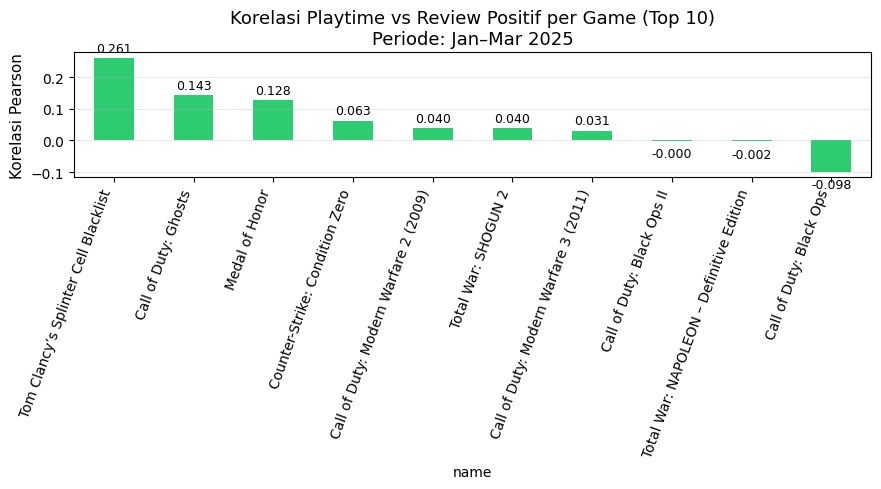

In [6]:
# ======================================================
# 🔹 EDA: Korelasi Playtime vs Review Positif per Game (Top 10)
#    (lokal → fallback GitHub)
# ======================================================

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from urllib.parse import quote

# --- 0) Sumber data: lokal dahulu, bila tidak ada → GitHub raw ---
LOCAL_CLEAN = "data/processed/steam_reviews_clean.csv"

BASE_URL = "https://raw.githubusercontent.com/fajaralgii04/bigdata-uts-ganjil-2526-/main/data/semua%20csv%20(gabungan)/"
GH_FILE  = "steam_reviews_clean.csv"   # sesuaikan jika beda nama

def read_csv_github(filename: str, **kwargs) -> pd.DataFrame:
    url = BASE_URL + quote(filename)
    print(f"🌐 Loading from GitHub: {url}")
    return pd.read_csv(url, **kwargs)

# === 1️⃣ Load data ===
if os.path.exists(LOCAL_CLEAN):
    print(f"📂 Loading local: {LOCAL_CLEAN}")
    df = pd.read_csv(LOCAL_CLEAN)
else:
    df = read_csv_github(GH_FILE)

# === 2️⃣ Filter time-bound (mis. Q1 2025) ===
# jika timestamp_created sudah datetime, ini tetap aman (errors='coerce')
df["timestamp_created"] = pd.to_datetime(df["timestamp_created"], errors="coerce")
df = df[(df["timestamp_created"] >= "2025-01-01") & (df["timestamp_created"] < "2025-04-01")]

# === 3️⃣ Pastikan tidak ada NaN di kolom utama ===
need_cols = ["name", "author_playtime_forever", "voted_up"]
for c in need_cols:
    if c not in df.columns:
        raise KeyError(f"Kolom '{c}' tidak ditemukan di dataset.")
df = df.dropna(subset=need_cols)

# === 4️⃣ Hitung korelasi Pearson per game ===
def safe_corr(g: pd.DataFrame) -> float:
    # ubah voted_up → int agar Pearson valid
    x = g["author_playtime_forever"]
    y = g["voted_up"].astype(int)
    # butuh variasi > 1 untuk korelasi bermakna
    if x.nunique() > 1 and y.nunique() > 1:
        return x.corr(y)
    return np.nan

corrs = (
    df.groupby("name")
      .apply(safe_corr)
      .dropna()
      .sort_values(ascending=False)
      .head(10)
)

# === 5️⃣ Plot ===
plt.figure(figsize=(9, 5))
corrs.plot(kind="bar", color="#2ecc71")  # hijau lembut
plt.title("Korelasi Playtime vs Review Positif per Game (Top 10)\nPeriode: Jan–Mar 2025", fontsize=13)
plt.ylabel("Korelasi Pearson", fontsize=11)
plt.grid(axis="y", alpha=0.3)
plt.xticks(rotation=70, ha="right")

# label nilai di atas batang
for i, v in enumerate(corrs.values):
    plt.text(i, v + (0.01 if v >= 0 else -0.02), f"{v:.3f}",
             ha="center", va="bottom" if v >= 0 else "top", fontsize=9, color="black")

plt.tight_layout()
plt.show()


**Pertanyaan 2** (SMART – Kapan & Bagaimana)

Selama periode 1 Januari – 31 Maret 2025, bagaimana perubahan proporsi review positif (voted_up) dari minggu ke minggu, dan apakah terdapat pola tren peningkatan atau penurunan pada tingkat kepuasan pemain di berbagai game populer di platform Steam?

📂 Loading local: data/processed/steam_reviews_clean.csv


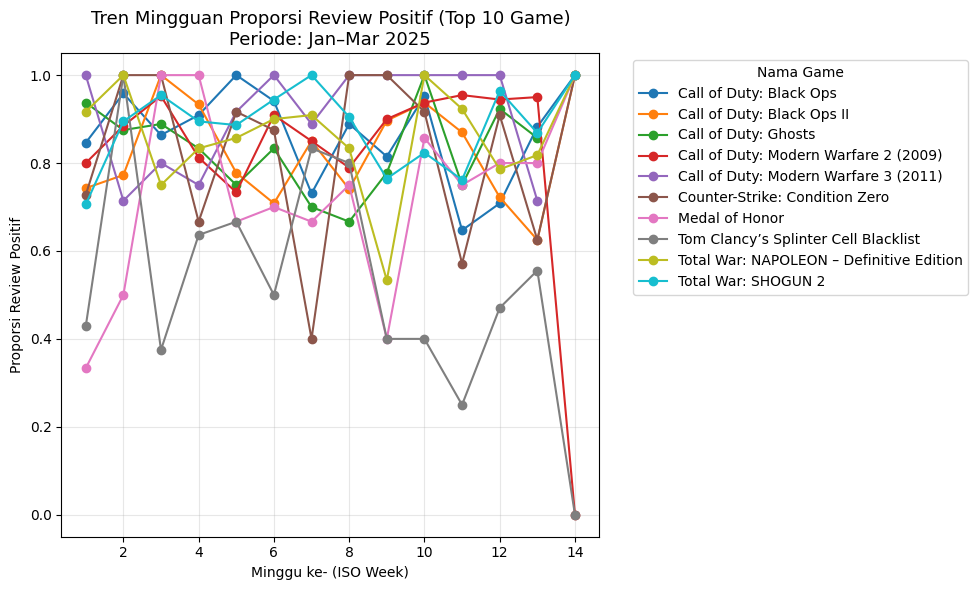

In [7]:
# ======================================================
# 🔹 EDA: Tren Mingguan Proporsi Review Positif (Top 10 Game)
#    (lokal → fallback GitHub)
# ======================================================

import os
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import quote

# --- 0) Sumber data: lokal dahulu, bila tidak ada → GitHub raw ---
LOCAL_CLEAN = "data/processed/steam_reviews_clean.csv"

BASE_URL = "https://raw.githubusercontent.com/fajaralgii04/bigdata-uts-ganjil-2526-/main/data/semua%20csv%20(gabungan)/"
GH_FILE  = "steam_reviews_clean.csv"   # sesuaikan jika nama di repo berbeda

def read_csv_github(filename: str, **kwargs) -> pd.DataFrame:
    url = BASE_URL + quote(filename)
    print(f"🌐 Loading from GitHub: {url}")
    return pd.read_csv(url, **kwargs)

# === 1️⃣ Load dataset ===
if os.path.exists(LOCAL_CLEAN):
    print(f"📂 Loading local: {LOCAL_CLEAN}")
    df = pd.read_csv(LOCAL_CLEAN)
else:
    df = read_csv_github(GH_FILE)

# === 2️⃣ Konversi waktu & filter periode Jan–Mar 2025 ===
df["timestamp_created"] = pd.to_datetime(df["timestamp_created"], errors="coerce")
df = df[(df["timestamp_created"] >= "2025-01-01") & (df["timestamp_created"] < "2025-04-01")]

# === 3️⃣ Ambil 10 game dengan review terbanyak ===
top_games = df["name"].value_counts().head(10).index
df_top = df[df["name"].isin(top_games)].copy()

# === 4️⃣ Tambah kolom minggu ke-n (ISO week) ===
df_top["week"] = df_top["timestamp_created"].dt.isocalendar().week.astype(int)

# === 5️⃣ Hitung proporsi review positif per minggu per game ===
weekly_trend = (
    df_top.groupby(["name", "week"], as_index=False)["voted_up"]
          .mean()
          .rename(columns={"voted_up": "proporsi_positif"})
          .sort_values(["name", "week"])
)

# === 6️⃣ Plot garis per game ===
plt.figure(figsize=(10, 6))
for game, g in weekly_trend.groupby("name"):
    plt.plot(g["week"], g["proporsi_positif"], marker="o", label=game)

plt.title("Tren Mingguan Proporsi Review Positif (Top 10 Game)\nPeriode: Jan–Mar 2025", fontsize=13)
plt.xlabel("Minggu ke- (ISO Week)")
plt.ylabel("Proporsi Review Positif")
plt.grid(alpha=0.3)
plt.legend(title="Nama Game", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


**pertanyaan 3** (SMART – Mengapa & Siapa)

Sejauh mana tingkat keterlibatan komunitas (jumlah interaksi seperti votes_up, votes_funny, dan word_count) berkorelasi dengan kemungkinan review positif (voted_up) pada platform Steam selama periode 1 Januari – 31 Maret 2025?
Game mana yang menunjukkan hubungan paling kuat antara keterlibatan pemain dan sentimen positif?

📂 Loading local: data/processed/steam_reviews_clean.csv


/tmp/ipython-input-3148151479.py:76: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(safe_corr)


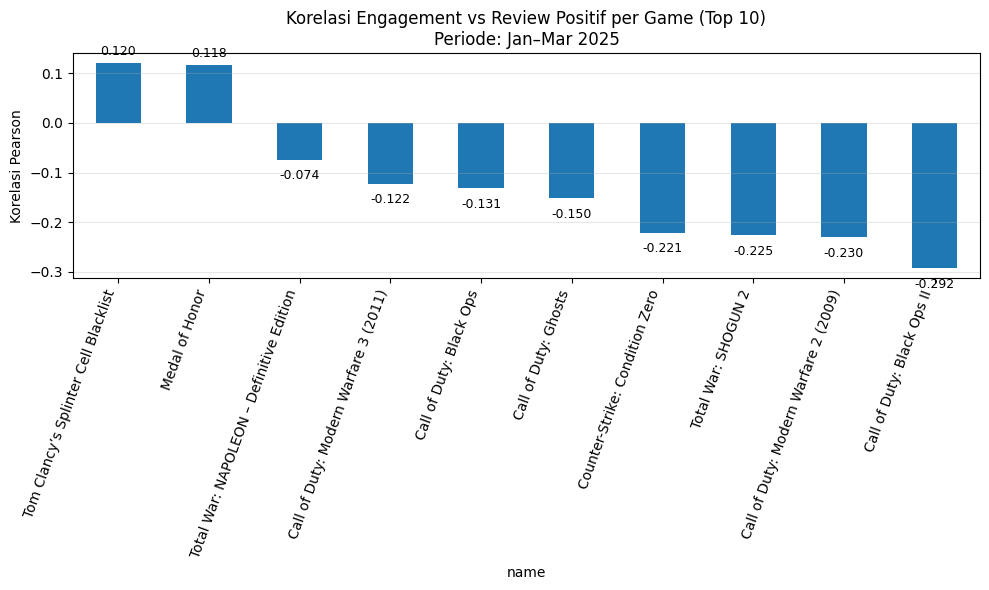

/tmp/ipython-input-3148151479.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("eng_q", as_index=False)["voted_up_int"]


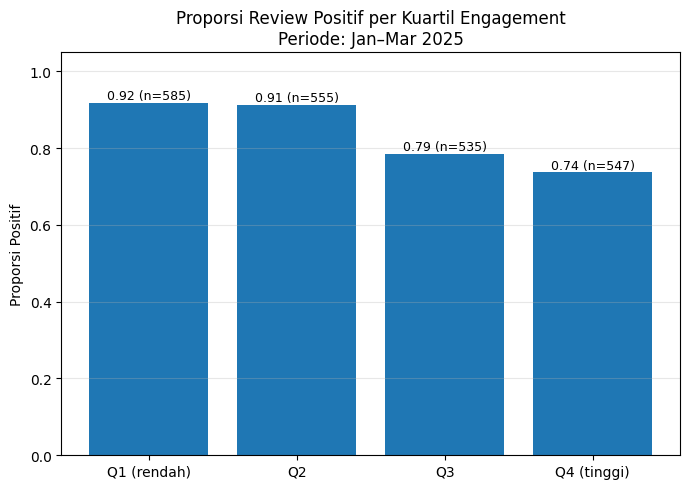

== Top-10 Game dengan Korelasi Engagement↔Positivity ==
                                          corr_engagement_positive
name                                                              
Tom Clancy’s Splinter Cell Blacklist                         0.120
Medal of Honor                                               0.118
Total War: NAPOLEON – Definitive Edition                    -0.074
Call of Duty: Modern Warfare 3 (2011)                       -0.122
Call of Duty: Black Ops                                     -0.131
Call of Duty: Ghosts                                        -0.150
Counter-Strike: Condition Zero                              -0.221
Total War: SHOGUN 2                                         -0.225
Call of Duty: Modern Warfare 2 (2009)                       -0.230
Call of Duty: Black Ops II                                  -0.292

== Positive Rate per Kuartil Engagement ==
         eng_q    n  pos_rate(%)
0  Q1 (rendah)  585        91.79
1           Q2  555        91.

In [8]:
# ======================================================
# 🔹 EDA SMART Q3 — Engagement ↔ Positivity (Jan–Mar 2025)
#    (lokal → fallback GitHub)
# ======================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.parse import quote

# --- 0) Sumber data: lokal dahulu, bila tidak ada → GitHub raw ---
LOCAL_CLEAN = "data/processed/steam_reviews_clean.csv"

BASE_URL = "https://raw.githubusercontent.com/fajaralgii04/bigdata-uts-ganjil-2526-/main/data/semua%20csv%20(gabungan)/"
GH_FILE  = "steam_reviews_clean.csv"   # sesuaikan jika beda nama

def read_csv_github(filename: str, **kwargs) -> pd.DataFrame:
    url = BASE_URL + quote(filename)
    print(f"🌐 Loading from GitHub: {url}")
    return pd.read_csv(url, **kwargs)

# ---- 1) Load & Time-bound ----
if os.path.exists(LOCAL_CLEAN):
    print(f"📂 Loading local: {LOCAL_CLEAN}")
    df = pd.read_csv(LOCAL_CLEAN, low_memory=False)
else:
    df = read_csv_github(GH_FILE, low_memory=False)

# pastikan datetime
df["timestamp_created"] = pd.to_datetime(df["timestamp_created"], errors="coerce")

# Periode SMART: Jan–Mar 2025 (end exclusive)
start, end = "2025-01-01", "2025-04-01"
df = df[(df["timestamp_created"] >= start) & (df["timestamp_created"] < end)].copy()

# Pastikan kolom tersedia
required = {"name","voted_up","votes_up","votes_funny","word_count"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}")

# Bersihkan NaN penting
df = df.dropna(subset=["name","voted_up","votes_up","votes_funny","word_count"]).copy()
df["voted_up_int"] = df["voted_up"].astype(int)

# ---- 2) Engagement score & winsorize (anti-outlier) ----
# pastikan numerik aman (jaga-jaga)
for c in ["votes_up","votes_funny","word_count"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

df["engagement_score"] = (
    df["votes_up"].clip(lower=0)
  + df["votes_funny"].clip(lower=0)
  + df["word_count"].clip(lower=0)
)

# winsorize p99 agar korelasi tidak didominasi outlier panjang/viral
if df["engagement_score"].notna().sum() > 0:
    p99 = df["engagement_score"].quantile(0.99)
else:
    p99 = 0
df["engagement_score_w"] = np.minimum(df["engagement_score"], p99)

# ---- 3) Korelasi Pearson per game ----
def safe_corr(g: pd.DataFrame):
    x = g["engagement_score_w"]
    y = g["voted_up_int"]
    # syarat variasi & sampel
    if x.nunique() < 2 or y.nunique() < 2 or len(g) < 20:
        return np.nan
    return x.corr(y)

corrs = (
    df.groupby("name", group_keys=False)
      .apply(safe_corr)
      .dropna()
      .sort_values(ascending=False)
)

top10 = corrs.head(10)

# ---- 4) Plot 1: Top-10 korelasi per game ----
plt.figure(figsize=(10,6))
top10.plot(kind="bar")
plt.title("Korelasi Engagement vs Review Positif per Game (Top 10)\nPeriode: Jan–Mar 2025")
plt.ylabel("Korelasi Pearson")
plt.xticks(rotation=70, ha="right")
plt.grid(axis="y", alpha=0.3)
# label angka
for i, v in enumerate(top10.values):
    plt.text(i, v + (0.01 if v >= 0 else -0.02), f"{v:.3f}",
             ha="center", va="bottom" if v >= 0 else "top", fontsize=9)
plt.tight_layout()
plt.show()

# ---- 5) Plot 2: Positive rate per kuartil engagement (global) ----
# Jika semua engagement sama, qcut bisa gagal → handle dengan duplicates='drop'
try:
    df["eng_q"] = pd.qcut(
        df["engagement_score_w"],
        4,
        labels=["Q1 (rendah)","Q2","Q3","Q4 (tinggi)"],
        duplicates="drop"
    )
except ValueError:
    # fallback: semua nilai sama → buat satu bucket
    df["eng_q"] = "Q-all"

quart = (
    df.groupby("eng_q", as_index=False)["voted_up_int"]
      .agg(pos_rate="mean", n="size")
)

plt.figure(figsize=(7,5))
plt.bar(quart["eng_q"].astype(str), quart["pos_rate"])
plt.title("Proporsi Review Positif per Kuartil Engagement\nPeriode: Jan–Mar 2025")
plt.ylabel("Proporsi Positif")
for i, (rate, n) in enumerate(zip(quart["pos_rate"], quart["n"])):
    plt.text(i, rate + 0.01, f"{rate:.2f} (n={n})", ha="center", fontsize=9)
plt.ylim(0, 1.05)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# ---- 6) Cetak ringkas angka kunci (untuk narasi) ----
print("== Top-10 Game dengan Korelasi Engagement↔Positivity ==")
print(top10.to_frame("corr_engagement_positive").round(3))

print("\n== Positive Rate per Kuartil Engagement ==")
print(
    quart.assign(**{"pos_rate(%)": (quart["pos_rate"]*100).round(2)})
         .drop(columns="pos_rate")
)


**Auldy Ranayu Sanny Prahasty Rachman (1103223216)**

Pertanyaan 1 (SMART – Apa & Mengapa)

Pada periode 1 Januari – 31 Maret 2025, bagaimana hubungan antara jumlah kata dalam review (word_count) dengan kemungkinan review positif (voted_up), dan mengapa hubungan tersebut dapat terjadi?

📂 Loading local: data/processed/steam_reviews_clean.csv


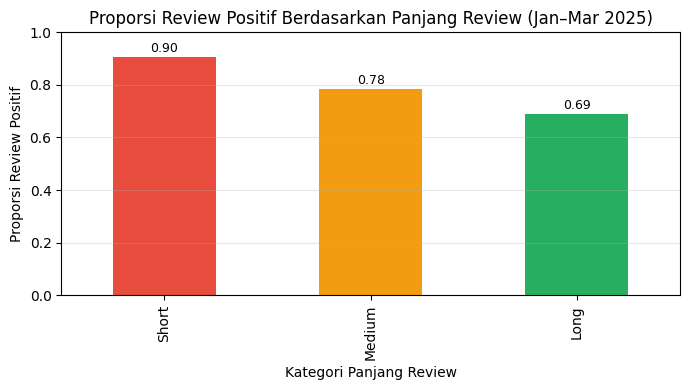

In [9]:
# ======================================================
# 🔹 EDA: Proporsi Review Positif vs Panjang Review (Jan–Mar 2025)
#    (lokal → fallback GitHub)
# ======================================================

import os
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import quote

# --- 0) Sumber data: lokal dahulu, bila tidak ada → GitHub raw ---
LOCAL_CLEAN = "data/processed/steam_reviews_clean.csv"

BASE_URL = "https://raw.githubusercontent.com/fajaralgii04/bigdata-uts-ganjil-2526-/main/data/semua%20csv%20(gabungan)/"
GH_FILE  = "steam_reviews_clean.csv"   # sesuaikan jika beda nama

def read_csv_github(filename: str, **kwargs) -> pd.DataFrame:
    url = BASE_URL + quote(filename)
    print(f"🌐 Loading from GitHub: {url}")
    return pd.read_csv(url, **kwargs)

# 1️⃣ Load data & filter waktu
if os.path.exists(LOCAL_CLEAN):
    print(f"📂 Loading local: {LOCAL_CLEAN}")
    df = pd.read_csv(LOCAL_CLEAN)
else:
    df = read_csv_github(GH_FILE)

need_cols = {"timestamp_created","word_count","voted_up"}
missing = need_cols - set(df.columns)
if missing:
    raise KeyError(f"Kolom wajib hilang: {missing}")

df["timestamp_created"] = pd.to_datetime(df["timestamp_created"], errors="coerce")
df = df[(df["timestamp_created"] >= "2025-01-01") & (df["timestamp_created"] < "2025-04-01")].copy()

# 2️⃣ Kategorisasi panjang review (guard NaN & tipe)
df["word_count"] = pd.to_numeric(df["word_count"], errors="coerce").fillna(0)

def cat_len(x: float) -> str:
    if x < 20: return "Short"
    elif x < 100: return "Medium"
    else: return "Long"

df["review_length_cat"] = df["word_count"].apply(cat_len)

# 3️⃣ Hitung proporsi review positif per kategori (pastikan boolean)
df["voted_up"] = df["voted_up"].astype(bool)
order = ["Short", "Medium", "Long"]
ratio = (
    df.groupby("review_length_cat", as_index=True)["voted_up"]
      .mean()
      .reindex(order)
)

# 4️⃣ Visualisasi
plt.figure(figsize=(7,4))
ratio.plot(kind="bar", color=["#e74c3c", "#f39c12", "#27ae60"])
plt.title("Proporsi Review Positif Berdasarkan Panjang Review (Jan–Mar 2025)")
plt.ylabel("Proporsi Review Positif")
plt.xlabel("Kategori Panjang Review")
plt.ylim(0, 1)
plt.grid(axis="y", alpha=0.3)

# Label nilai
for i, v in enumerate(ratio.values):
    if pd.notna(v):
        plt.text(i, min(v + 0.02, 1.02), f"{v:.2f}", ha="center", fontsize=9)

plt.tight_layout()
plt.show()


Pertanyaan 2 (SMART – Dimana & Bagaimana)

Pada periode 1 Januari – 31 Maret 2025, game mana yang memiliki tingkat keterlibatan (engagement) tertinggi berdasarkan jumlah interaksi pemain (votes_up dan votes_funny), dan bagaimana keterlibatan tersebut tercermin dalam jumlah rata-rata vote yang diterima?


📂 Loading local: data/processed/steam_reviews_clean.csv


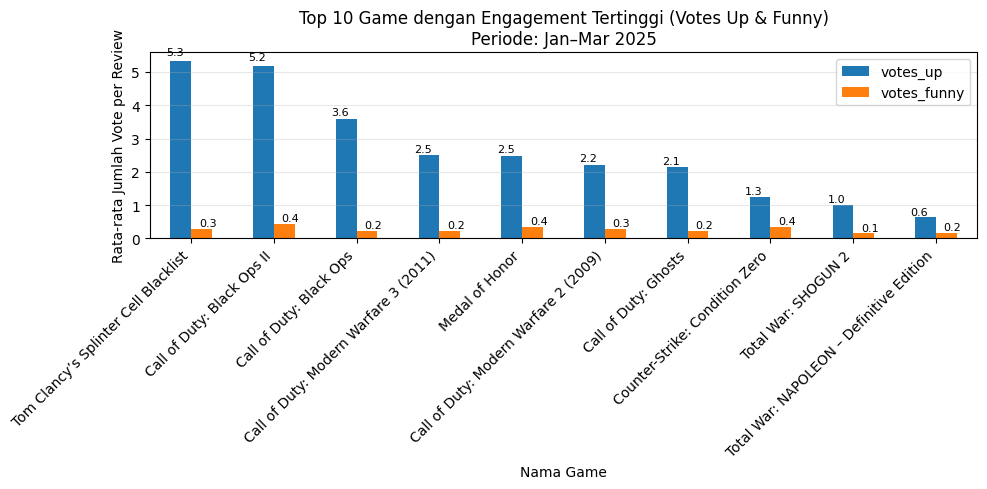

In [10]:
# ======================================================
# 🔹 EDA: Top 10 Game dengan Engagement Tertinggi (Votes Up & Funny)
#    (lokal → fallback GitHub)
# ======================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import quote

# --- 0) Sumber data: lokal dahulu, bila tidak ada → GitHub raw ---
LOCAL_CLEAN = "data/processed/steam_reviews_clean.csv"
BASE_URL    = "https://raw.githubusercontent.com/fajaralgii04/bigdata-uts-ganjil-2526-/main/data/semua%20csv%20(gabungan)/"
GH_FILE     = "steam_reviews_clean.csv"   # sesuaikan jika beda nama

def read_csv_github(filename: str, **kwargs) -> pd.DataFrame:
    url = BASE_URL + quote(filename)
    print(f"🌐 Loading from GitHub: {url}")
    return pd.read_csv(url, **kwargs)

# 1️⃣ Load data & filter periode waktu
if os.path.exists(LOCAL_CLEAN):
    print(f"📂 Loading local: {LOCAL_CLEAN}")
    df = pd.read_csv(LOCAL_CLEAN)
else:
    df = read_csv_github(GH_FILE)

need_cols = {"timestamp_created","name","votes_up","votes_funny"}
missing = need_cols - set(df.columns)
if missing:
    raise KeyError(f"Kolom wajib hilang: {missing}")

df["timestamp_created"] = pd.to_datetime(df["timestamp_created"], errors="coerce")
df = df[(df["timestamp_created"] >= "2025-01-01") & (df["timestamp_created"] < "2025-04-01")].copy()

# jaga numerik
for c in ["votes_up","votes_funny"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

# 2️⃣ Hitung engagement rata-rata per game
eng = (
    df.groupby("name")[["votes_up", "votes_funny"]]
      .mean()
      .sort_values("votes_up", ascending=False)
      .head(10)
)

# 3️⃣ Visualisasi top 10 game dengan engagement tertinggi
ax = eng.plot(kind="bar", figsize=(10,5))
plt.title("Top 10 Game dengan Engagement Tertinggi (Votes Up & Funny)\nPeriode: Jan–Mar 2025", fontsize=12)
plt.ylabel("Rata-rata Jumlah Vote per Review")
plt.xlabel("Nama Game")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)

# Tambahkan label angka di atas tiap batang (akurasi posisi antar kolom)
n_groups = len(eng)
n_cols   = len(eng.columns)  # 2 kolom: votes_up & votes_funny
x = np.arange(n_groups)
barw = 0.8 / n_cols

for i, col in enumerate(eng.columns):
    yvals = eng[col].values
    for xi, yi in zip(x, yvals):
        xpos = xi - 0.4 + (i + 0.5) * barw   # offset per kolom dalam grup
        plt.text(xpos, yi + max(0.02, 0.02*yi), f"{yi:.1f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()


Pertanyaan 3 (SMART – Kapan & Siapa):

Pada periode Januari–Desember 2025, kapan aktivitas pemain paling tinggi terjadi, dan game mana yang memiliki pertumbuhan jumlah review paling konsisten sepanjang tahun?


📂 Loading local: data/processed/steam_reviews_clean.csv


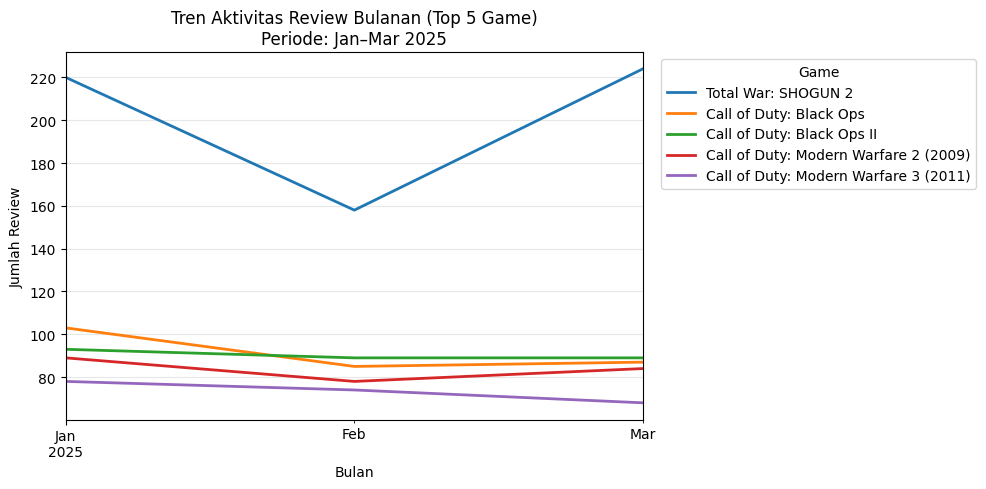

In [11]:
# ======================================================
# 🔹 EDA: Tren Aktivitas Review Bulanan (Top 5 Game) — Jan–Mar 2025
#    (lokal → fallback GitHub)
# ======================================================

import os
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import quote

# --- 0) Sumber data: lokal dahulu, bila tidak ada → GitHub raw ---
LOCAL_CLEAN = "data/processed/steam_reviews_clean.csv"
BASE_URL    = "https://raw.githubusercontent.com/fajaralgii04/bigdata-uts-ganjil-2526-/main/data/semua%20csv%20(gabungan)/"
GH_FILE     = "steam_reviews_clean.csv"   # sesuaikan jika beda nama

def read_csv_github(filename: str, **kwargs) -> pd.DataFrame:
    url = BASE_URL + quote(filename)
    print(f"🌐 Loading from GitHub: {url}")
    return pd.read_csv(url, **kwargs)

# 1️⃣ Load data & konversi waktu
if os.path.exists(LOCAL_CLEAN):
    print(f"📂 Loading local: {LOCAL_CLEAN}")
    df = pd.read_csv(LOCAL_CLEAN)
else:
    df = read_csv_github(GH_FILE)

need_cols = {"timestamp_created","name"}
missing = need_cols - set(df.columns)
if missing:
    raise KeyError(f"Kolom wajib hilang: {missing}")

df["timestamp_created"] = pd.to_datetime(df["timestamp_created"], errors="coerce")

# 2️⃣ Tambah kolom bulan (Month-Year)
df["month"] = df["timestamp_created"].dt.to_period("M").dt.to_timestamp()

# 3️⃣ Filter periode Januari–Maret 2025
df = df[(df["month"] >= "2025-01-01") & (df["month"] < "2025-04-01")].copy()

# 4️⃣ Agregasi jumlah review per game per bulan
monthly_game = df.groupby(["name", "month"], as_index=False).size()
pivot = monthly_game.pivot(index="month", columns="name", values="size").fillna(0)

# 5️⃣ Pilih 5 game dengan total review terbanyak
top_games = pivot.sum(axis=0).sort_values(ascending=False).head(5).index

# 6️⃣ Visualisasi tren bulanan review
ax = pivot[top_games].plot(figsize=(10,5), linewidth=2)
plt.title("Tren Aktivitas Review Bulanan (Top 5 Game)\nPeriode: Jan–Mar 2025")
plt.xlabel("Bulan")
plt.ylabel("Jumlah Review")
plt.legend(title="Game", bbox_to_anchor=(1.02,1), loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


-

-

-

-

KLASIFIKASI

Memprediksi apakah review pemain bersifat positif (voted_up=True) atau negatif (False).

📂 Loading local: data/processed/X_train.csv
📂 Loading local: data/processed/X_test.csv
📂 Loading local: data/processed/y_train.csv
📂 Loading local: data/processed/y_test.csv

=== SVM ===
Akurasi : 0.821
Presisi : 0.823
Recall  : 0.996
F1-Score: 0.901


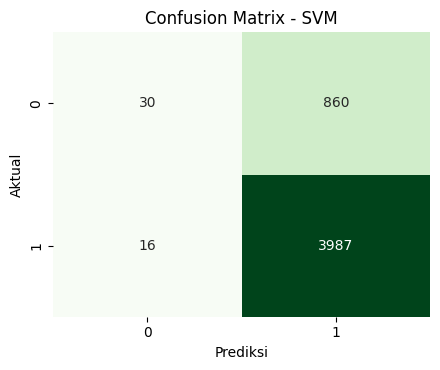


=== Random Forest ===
Akurasi : 0.803
Presisi : 0.859
Recall  : 0.908
F1-Score: 0.883


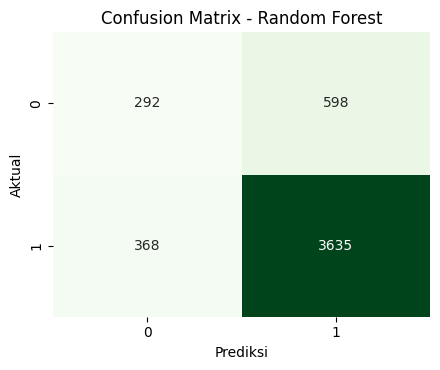

In [12]:
# ==========================================
# 🔹 KLASIFIKASI: SVM dan RANDOM FOREST
#    (lokal → fallback GitHub)
# ==========================================

import os
import pandas as pd
from urllib.parse import quote

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- 0) Helper loader: lokal dulu, kalau tidak ada → GitHub raw ---
BASE_URL = "https://raw.githubusercontent.com/fajaralgii04/bigdata-uts-ganjil-2526-/main/data/semua%20csv%20(gabungan)/"

def read_csv_github(filename: str, **kwargs) -> pd.DataFrame:
    url = BASE_URL + quote(filename)
    print(f"🌐 Loading from GitHub: {url}")
    return pd.read_csv(url, **kwargs)

def load_split(name: str) -> pd.DataFrame:
    local_path = f"data/processed/{name}.csv"
    if os.path.exists(local_path):
        print(f"📂 Loading local: {local_path}")
        return pd.read_csv(local_path)
    # fallback ke GitHub
    return read_csv_github(f"{name}.csv")

# 1️⃣ Load data hasil preprocessing (X/y split)
X_train = load_split("X_train")
X_test  = load_split("X_test")
y_train = load_split("y_train").squeeze()
y_test  = load_split("y_test").squeeze()

# jaga tipe target boolean
if y_train.dtype != bool:
    y_train = y_train.astype(bool)
if y_test.dtype != bool:
    y_test = y_test.astype(bool)

# 2️⃣ Model SVM
svm = SVC(kernel="rbf", random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# 3️⃣ Model Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 4️⃣ Evaluasi fungsi umum
def eval_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    print(f"\n=== {name} ===")
    print(f"Akurasi : {acc:.3f}")
    print(f"Presisi : {pre:.3f}")
    print(f"Recall  : {rec:.3f}")
    print(f"F1-Score: {f1:.3f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4.5,3.8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Prediksi")
    plt.ylabel("Aktual")
    plt.tight_layout()
    plt.show()

# 5️⃣ Evaluasi kedua model
eval_model("SVM", y_test, y_pred_svm)
eval_model("Random Forest", y_test, y_pred_rf)


B. REGRESI — LINEAR REGRESSION & XGBOOST
Tujuan:

Memprediksi jumlah upvotes (votes_up) yang diterima oleh sebuah review.

📂 Loading local: data/processed/X_train.csv
📂 Loading local: data/processed/X_test.csv

=== Linear Regression ===
MSE : 1.043
RMSE: 1.021
R²  : 0.172

=== XGBoost ===
MSE : 0.972
RMSE: 0.986
R²  : 0.229


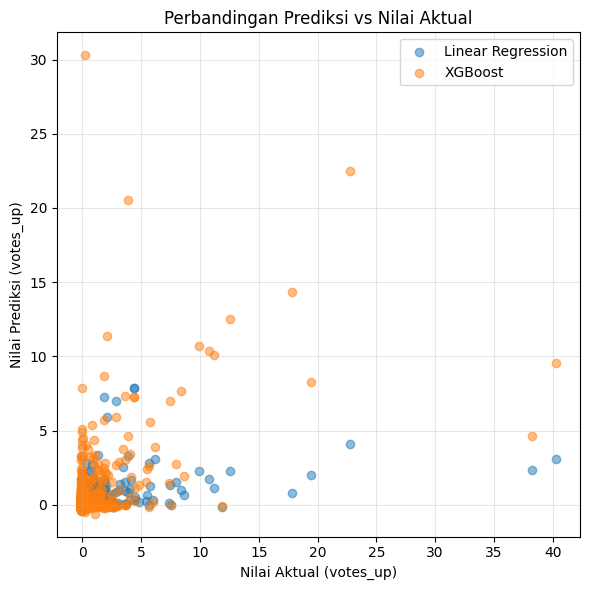

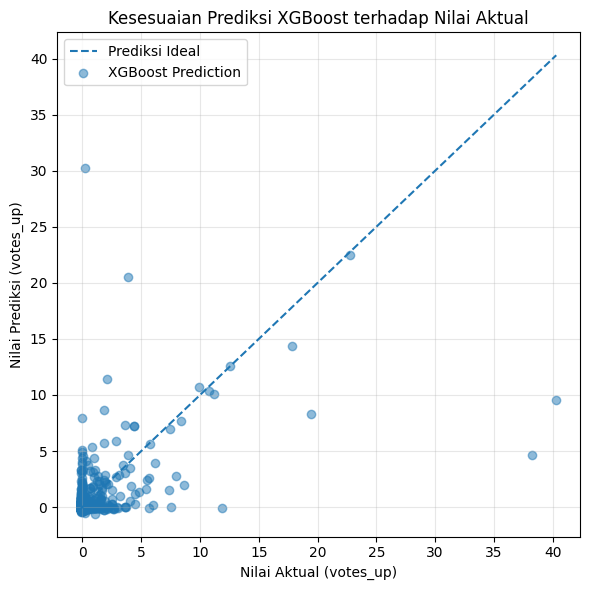

In [13]:
# ==========================================
# 🔹 REGRESI: LINEAR REGRESSION & XGBOOST
#    (lokal → fallback GitHub) + anti data leakage
# ==========================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import quote

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- 0) Loader: lokal dulu, kalau tidak ada → GitHub raw ---
BASE_URL = "https://raw.githubusercontent.com/fajaralgii04/bigdata-uts-ganjil-2526-/main/data/semua%20csv%20(gabungan)/"

def read_csv_github(filename: str, **kwargs) -> pd.DataFrame:
    url = BASE_URL + quote(filename)
    print(f"🌐 Loading from GitHub: {url}")
    return pd.read_csv(url, **kwargs)

def load_split(name: str) -> pd.DataFrame:
    local_path = f"data/processed/{name}.csv"
    if os.path.exists(local_path):
        print(f"📂 Loading local: {local_path}")
        return pd.read_csv(local_path)
    return read_csv_github(f"{name}.csv")

# 1️⃣ Load data split (hasil preprocessing)
X_train = load_split("X_train")
X_test  = load_split("X_test")

# Target: votes_up  → HINDARI LEAKAGE: drop 'votes_up' dari fitur
if "votes_up" not in X_train.columns or "votes_up" not in X_test.columns:
    raise KeyError("Kolom 'votes_up' tidak ditemukan di X_train/X_test. Pastikan preprocessing menyertakan kolom ini.")

y_train_reg = X_train["votes_up"].astype(float).copy()
y_test_reg  = X_test["votes_up"].astype(float).copy()

X_train_reg = X_train.drop(columns=["votes_up"], errors="ignore").copy()
X_test_reg  = X_test.drop(columns=["votes_up"], errors="ignore").copy()

# 2️⃣ Model Linear Regression
lr = LinearRegression()
lr.fit(X_train_reg, y_train_reg)
pred_lr = lr.predict(X_test_reg)

# 3️⃣ Model XGBoost
xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
)
xgb.fit(X_train_reg, y_train_reg)
pred_xgb = xgb.predict(X_test_reg)

# 4️⃣ Evaluasi fungsi umum
def eval_reg(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n=== {name} ===")
    print(f"MSE : {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²  : {r2:.3f}")

# 5️⃣ Evaluasi hasil model
eval_reg("Linear Regression", y_test_reg, pred_lr)
eval_reg("XGBoost", y_test_reg, pred_xgb)

# ==========================================
# 🔹 VISUALISASI HASIL REGRESI
# ==========================================

# Scatter plot: aktual vs prediksi (kedua model)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_reg, pred_lr, alpha=0.5, label="Linear Regression")
plt.scatter(y_test_reg, pred_xgb, alpha=0.5, label="XGBoost")
plt.xlabel("Nilai Aktual (votes_up)")
plt.ylabel("Nilai Prediksi (votes_up)")
plt.title("Perbandingan Prediksi vs Nilai Aktual")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Garis diagonal (prediksi ideal) vs XGBoost
plt.figure(figsize=(6, 6))
lo, hi = float(y_test_reg.min()), float(y_test_reg.max())
plt.plot([lo, hi], [lo, hi], linestyle="--", label="Prediksi Ideal")
plt.scatter(y_test_reg, pred_xgb, alpha=0.5, label="XGBoost Prediction")
plt.xlabel("Nilai Aktual (votes_up)")
plt.ylabel("Nilai Prediksi (votes_up)")
plt.title("Kesesuaian Prediksi XGBoost terhadap Nilai Aktual")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


CLUSTERING — K-MEANS & DBSCAN
Tujuan:

Mengelompokkan game berdasarkan pola engagement pemain (unsupervised learning).

📂 Loading local: data/processed/steam_reviews_preprocessed.csv


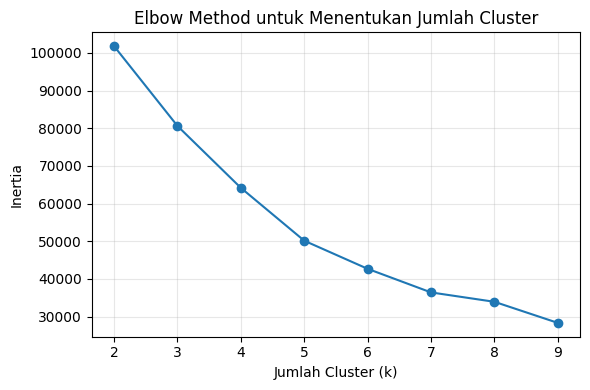

K-Means: Silhouette Score = 0.380
DBSCAN: Silhouette Score = 0.301


In [14]:
# ==========================================
# 🔹 CLUSTERING: K-MEANS & DBSCAN
#    (lokal → fallback GitHub) + guard silhouette
# ==========================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import quote
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# --- 0) Loader: lokal dulu, kalau tidak ada → GitHub raw ---
LOCAL_PREP = "data/processed/steam_reviews_preprocessed.csv"
BASE_URL   = "https://raw.githubusercontent.com/fajaralgii04/bigdata-uts-ganjil-2526-/main/data/semua%20csv%20(gabungan)/"
GH_FILE    = "steam_reviews_preprocessed.csv"  # sesuaikan jika beda nama

def read_csv_github(filename: str, **kwargs) -> pd.DataFrame:
    url = BASE_URL + quote(filename)
    print(f"🌐 Loading from GitHub: {url}")
    return pd.read_csv(url, **kwargs)

# 1️⃣ Load dataset numerik
if os.path.exists(LOCAL_PREP):
    print(f"📂 Loading local: {LOCAL_PREP}")
    X = pd.read_csv(LOCAL_PREP)
else:
    X = read_csv_github(GH_FILE)

need_cols = ["word_count","votes_up","votes_funny","author_playtime_forever","price"]
missing = set(need_cols) - set(X.columns)
if missing:
    raise KeyError(f"Kolom wajib hilang: {missing}")

X_num = X[need_cols].copy()
# jaga numerik + scale (jika file belum di-scale)
for c in need_cols:
    X_num[c] = pd.to_numeric(X_num[c], errors="coerce").fillna(0)

# jika kamu yakin file sudah distandardize di preprocessing, blok scaler bisa dilewati.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# 2️⃣ Elbow Method (K=2..9)
inertia, K_range = [], range(2, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(K_range), inertia, marker="o")
plt.title("Elbow Method untuk Menentukan Jumlah Cluster")
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Inertia")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 3️⃣ Jalankan model K-Means dan DBSCAN
kmeans = KMeans(n_clusters=3, n_init="auto", random_state=42)
labels_km = kmeans.fit_predict(X_scaled)

dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_db = dbscan.fit_predict(X_scaled)

# 4️⃣ Evaluasi Silhouette Score (hanya valid jika ≥2 cluster berbeda)
def safe_silhouette(Xarr, labels, name):
    uniq = np.unique(labels)
    # DBSCAN bisa hasilkan semua -1 (noise) atau cuma 1 cluster → tidak valid
    if len(uniq) < 2 or (len(uniq) == 2 and -1 in uniq and (labels != -1).sum() == 0):
        print(f"{name}: Silhouette tidak dapat dihitung (cluster < 2 / semua noise).")
        return np.nan
    try:
        score = silhouette_score(Xarr, labels)
        print(f"{name}: Silhouette Score = {score:.3f}")
        return score
    except Exception as e:
        print(f"{name}: Gagal hitung silhouette → {e}")
        return np.nan

score_km = safe_silhouette(X_scaled, labels_km, "K-Means")
score_db = safe_silhouette(X_scaled, labels_db, "DBSCAN")
